In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statsmodels.api as sm

In [1]:
filename = 'data/week03_wcoa_cruise/WCOA2013_hy1.csv'

In [4]:
df = pd.read_csv(filename,header=31,na_values=-999,parse_dates=[[8,9]])
df.head()

DATE_TIME      EXPOCODE   SECT_ID  LEG LINE  STNNBR  CASTNO  \
0 2013-08-05 02:12:20  317W20130803  WCOA2013    1    2      11       1   
1 2013-08-05 02:12:53  317W20130803  WCOA2013    1    2      11       1   
2 2013-08-05 02:19:58  317W20130803  WCOA2013    1    2      11       1   
3 2013-08-05 02:27:01  317W20130803  WCOA2013    1    2      11       1   
4 2013-08-05 02:30:53  317W20130803  WCOA2013    1    2      11       1   

   BTLNBR  BTLNBR_FLAG_W  LATITUDE   ...    TCARBN  TCARBN_FLAG_W  ALKALI  \
0       1              2      48.2   ...    2370.2              2  2369.0   
1       2              2      48.2   ...       NaN              9     NaN   
2       3              2      48.2   ...    2349.6              2  2343.7   
3       4              2      48.2   ...    2318.7              2  2311.9   
4       5              2      48.2   ...    2300.0              2  2299.7   

   ALKALI_FLAG_W  PH_TOT  PH_TOT_FLAG_W  PH_TMP    CO32  CO32__FLAG_W  CHLORA  
0              2   7.294              2    25.0     NaN             9     NaN  
1              9   7.295              2    25.0     NaN             9     NaN  
2              2   7.282              2    25.0  43.521             3     NaN  
3              2   7.287              2    25.0  45.641             2     NaN  
4              2   7.308              2    25.0  47.741             2     NaN  

[5 rows x 42 columns]

### Multiple regression exercise

Goal is to predict pH based on the T,S,p,O2 using a standard multiple regression

First create a subset of data:
* Finite data (not NaN)
* 30 > pressure > 300

In [13]:
# CTDOXY, CTDSAL, CTDPRS, CTDTMP
subdf = df[ (np.isfinite(df['CTDOXY']) &
             np.isfinite(df['CTDTMP']) & 
             np.isfinite(df['CTDPRS']) & 
             np.isfinite(df['CTDSAL']) & 
             np.isfinite(df['PH_TOT']) &
             (df['CTDPRS'] >= 30) & 
             (df['CTDPRS'] <= 300 ) )]

index, = np.where((df['CTDPRS'] > 30) & (df['CTDPRS'] < 300) & np.isfinite(df['CTDOXY'] + df['CTDTMP'] + df['CTDPRS'] + df['CTDSAL']))

print('N =',len(index))

N = 464


In [14]:
# vector of pH
y = subdf['PH_TOT']

# matrix of predictor variables
pres = subdf['CTDPRS']
temp = subdf['CTDTMP']
sal = subdf['CTDSAL']
oxy = subdf['CTDOXY']
A = np.array([np.ones(len(pres)),pres,temp,sal,oxy])
A = np.transpose(A)

print(A)

[[   1.      197.8       6.7236   33.904   149.1   ]
 [   1.      153.7       7.205    33.817   124.4   ]
 [   1.      128.5       7.3828   33.67    155.6   ]
 ..., 
 [   1.       60.5      10.7555   33.647   169.6   ]
 [   1.       40.4      11.437    33.606   221.9   ]
 [   1.       30.2      12.4522   33.589   247.6   ]]


Find the unknown coefficients that provide the best least squares fit.

In [9]:
coeff = np.linalg.lstsq(A,y)[0]

Plot the modeled vs. observed values and the residuals.

R-Squared: 0.966327583834


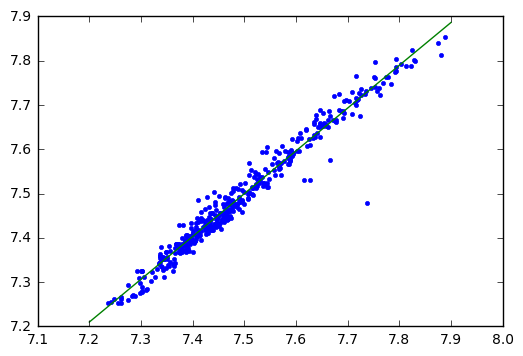

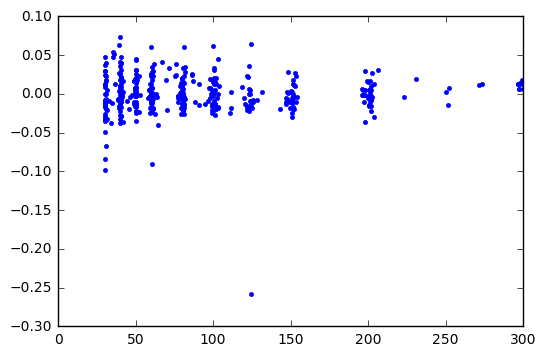

In [16]:
y_1 = coeff[0] + coeff[1]* pres + coeff[2]*temp + coeff[3]*sal + coeff[4]*oxy
#OR
y_1 = np.dot(A,coeff)

residual = y_1 - y
slope, intercept, r_value, p_value, std_err = stats.linregress(y,y_1)

fig,ax = plt.subplots()
ax.plot(y,y_1,'.')
x_line = np.linspace(7.2,7.9,299)
y_line = slope*x_line + intercept
ax.plot(x_line,y_line)

# Plot the residual
fig,ax = plt.subplots()
ax.plot(subdf['CTDPRS'],residual,'.')

print('R-Squared:',r_value**2)

The `statsmodels` package can provide statistical analysis on the significance of the least squares fit, including the F statistic and adjusted R-squared.

See http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html

In [10]:
res = sm.OLS(y, A).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 PH_TOT   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     2992.
Date:                Sat, 11 Mar 2017   Prob (F-statistic):          1.75e-305
Time:                        09:33:41   Log-Likelihood:                 962.59
No. Observations:                 422   AIC:                            -1915.
Df Residuals:                     417   BIC:                            -1895.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          7.0659      0.142     49.878      0.0

### Notes
* The R-squared and adjusted R-squared are high, but it would also be useful to compute the variance inflation factor to check for multicollinearity.
* The warning about the high condition number occurs because we used variables with very different magnitudes. This can lead to problems like round-off errors when subtracting small number from big number. Standardizing the input variables and transforming them to z-scores would help solve this problem.